# TAREA 1

## Configuración

In [6]:
import cv2
import numpy as np
#import os
#os.chdir(r"c:\Users\paumq\OneDrive\Documentos")

# Rangos HSV
COBRE_LOW, COBRE_HIGH = np.array([0, 80, 50]), np.array([15, 255, 255])
ORO_LOW, ORO_HIGH     = np.array([16, 60, 100]), np.array([45, 255, 255])
GRIS_LOW, GRIS_HIGH   = np.array([0, 0, 40]), np.array([180, 60, 255])

# Especificaciones de monedas en mm
COIN_SPECS = {
    '2 Euros': 25.75,
    '1 Euro': 23.25,
    '50 cent': 24.25,
    '20 cent': 22.25,
    '10 cent': 19.75,
    '5 cent': 21.25,
    '2 cent': 18.75,
    '1 cent': 16.25
}

# Valores monetarios
COIN_VALUES = {
    '2 Euros': 2.00,
    '1 Euro': 1.00,
    '50 cent': 0.50,
    '20 cent': 0.20,
    '10 cent': 0.10,
    '5 cent': 0.05,
    '2 cent': 0.02,
    '1 cent': 0.01
}

## Detección

In [7]:

def detectar_monedas(imagen_path):
    imagen = cv2.imread(imagen_path)
    if imagen is None:
        raise FileNotFoundError(f"No se encontró la imagen: {imagen_path}")

    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 7)

    circulos = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT,
        dp=1.2, minDist=80,
        param1=100, param2=40,
        minRadius=40, maxRadius=120
    )

    if circulos is None:
        raise RuntimeError("No se detectaron monedas.")

    return imagen, np.uint16(np.around(circulos))

## Clasificación

In [8]:

def clasificar_por_color(imagen, circulos):
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    gray = cv2.GaussianBlur(cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY), (5,5), 2)

    monedas = []
    for (x, y, r) in circulos[0, :]:
        mask_total = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask_total, (x, y), r, 255, -1)

        mask_centro = np.zeros_like(mask_total)
        cv2.circle(mask_centro, (x, y), int(r * 0.5), 255, -1)
        mask_anillo = cv2.subtract(mask_total, mask_centro)

        hsv_centro = cv2.mean(hsv, mask=mask_centro)[:3]
        hsv_anillo = cv2.mean(hsv, mask=mask_anillo)[:3]
        h_c, s_c, _ = hsv_centro
        h_a, s_a, _ = hsv_anillo

        grupo = "Desconocido"
        if COBRE_LOW[0] <= h_c <= COBRE_HIGH[0] and COBRE_LOW[0] <= h_a <= COBRE_HIGH[0]:
            grupo = "Cobre"
        elif ORO_LOW[0] <= h_c <= ORO_HIGH[0] and ORO_LOW[0] <= h_a <= ORO_HIGH[0]:
            grupo = "Oro"
        else:
            delta_s = s_a - s_c
            if delta_s > 5 and 10 < h_a < 50:
                grupo = "1 Euro"
            elif delta_s < -5 and 10 < h_c < 50:
                grupo = "2 Euros"

        monedas.append((x, y, r, grupo))
    return monedas


def clasificar_por_tamano(monedas, mm_per_px):
    monedas_finales = []
    for (x, y, r, grupo) in monedas:
        diam_mm = (2 * r) * mm_per_px
        if grupo == "Oro":
            grupo = min(['50 cent', '20 cent', '10 cent'], key=lambda k: abs(diam_mm - COIN_SPECS[k]))
        elif grupo == "Cobre":
            grupo = min(['5 cent', '2 cent', '1 cent'], key=lambda k: abs(diam_mm - COIN_SPECS[k]))
        monedas_finales.append((x, y, r, grupo))

    return monedas_finales


## Selección 

In [9]:
def seleccionar_referencia(imagen, monedas_detectadas, escala_vista=0.7):
    ref_selected = False
    mm_per_px = None

    def on_mouse(event, x, y, flags, param):
        nonlocal ref_selected, mm_per_px
        if event == cv2.EVENT_LBUTTONDOWN:
            distances = [(abs(x - cx) + abs(y - cy), (cx, cy, r)) for (cx, cy, r, _) in monedas_detectadas]
            distances.sort(key=lambda d: d[0])
            cx, cy, r = distances[0][1]
            ref_px_diam = 2 * r
            ref_mm_diam = 23.25  # diámetro de 1€
            mm_per_px = ref_mm_diam / ref_px_diam
            ref_selected = True
            print(f"\nReferencia seleccionada: 1€ — Escala = {mm_per_px:.4f} mm/pixel\n")

    temp = imagen.copy()
    for (x, y, r, _) in monedas_detectadas:
        cv2.circle(temp, (x, y), r, (0, 255, 0), 2)

    temp_resized = cv2.resize(temp, None, fx=escala_vista, fy=escala_vista)
    def on_mouse_scaled(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            real_x = int(x / escala_vista)
            real_y = int(y / escala_vista)
            on_mouse(event, real_x, real_y, flags, param)

    cv2.namedWindow("Selecciona moneda de 1 euro")
    cv2.setMouseCallback("Selecciona moneda de 1 euro", on_mouse_scaled)

    while True:
        cv2.imshow("Selecciona moneda de 1 euro", temp_resized)
        key = cv2.waitKey(10)
        if ref_selected:
            break
        if key == 27:
            cv2.destroyAllWindows()
            raise SystemExit("Cancelado por el usuario.")

    cv2.destroyAllWindows()
    return mm_per_px


## Main

In [ ]:
imagenes = ["Monedas.jpg", "Monedas2.jpg", "Monedas3.jpg", "Monedas4.jpg,", "Monedas5.jpg", "Monedas6.jpg"]
# o desde una carpeta
import os

def procesar_imagen(imagen_path):
    print(f"\nProcesando {imagen_path} ...")
    
    # Detección
    imagen, circulos = detectar_monedas(imagen_path)
    monedas_detectadas_temp = [(x, y, r, "") for (x, y, r) in circulos[0, :]]

    # Selección de referencia
    mm_per_px = seleccionar_referencia(imagen, monedas_detectadas_temp)

    # Clasificación
    monedas_color = clasificar_por_color(imagen, circulos)
    monedas_finales = clasificar_por_tamano(monedas_color, mm_per_px)

    # Calcular total y dibujar resultados
    total = 0.0
    output = imagen.copy()
    for (x, y, r, nombre) in monedas_finales:
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        cv2.putText(output, nombre, (x - 50, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        total += COIN_VALUES.get(nombre, 0)

    cv2.putText(output, f"Total: {total:.2f} €", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    print(f"💰 Total contado: {total:.2f} €")

    output_resized = cv2.resize(output, None, fx=0.7, fy=0.7)
    cv2.imshow(f"Clasificacion: {imagen_path}", output_resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main():
    imagenes = ["Monedas.jpg", "Monedas2.jpg", "Monedas3.jpg", "Monedas4.jpg", "Monedas5.jpg", "Monedas6.jpg"]

    for imagen_path in imagenes:
        procesar_imagen(imagen_path)


if __name__ == "__main__":
    main()




Procesando Monedas.jpg ...


C:\Users\hsuli\AppData\Local\Temp\ipykernel_27240\1458872864.py:8: RuntimeWarning: overflow encountered in scalar subtract
  distances = [(abs(x - cx) + abs(y - cy), (cx, cy, r)) for (cx, cy, r, _) in monedas_detectadas]
C:\Users\hsuli\AppData\Local\Temp\ipykernel_27240\1458872864.py:8: RuntimeWarning: overflow encountered in scalar add
  distances = [(abs(x - cx) + abs(y - cy), (cx, cy, r)) for (cx, cy, r, _) in monedas_detectadas]



Referencia seleccionada: 1€ — Escala = 0.1401 mm/pixel

💰 Total contado: 4.31 €

Procesando Monedas2.jpg ...

Referencia seleccionada: 1€ — Escala = 0.1264 mm/pixel

💰 Total contado: 3.58 €

Procesando Monedas3.jpg ...

Referencia seleccionada: 1€ — Escala = 0.1264 mm/pixel

💰 Total contado: 3.88 €

Procesando Monedas4.jpg ...

Referencia seleccionada: 1€ — Escala = 0.1129 mm/pixel

💰 Total contado: 3.44 €

Procesando Monedas5.jpg ...

Referencia seleccionada: 1€ — Escala = 0.1510 mm/pixel

💰 Total contado: 1.58 €

Procesando Monedas6.jpg ...

Referencia seleccionada: 1€ — Escala = 0.1336 mm/pixel

💰 Total contado: 5.61 €


# TAREA 2

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cv2 import imread
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

## Configuración

In [2]:
TRAIN = [
    ("TAR.png", "fragmentos_negros"),
    ("PEL.png", "pellets_esfericos"),
    ("FRA.png", "films_translucidos"),
]
TEST_IMG = "MPs_test.jpg"
TEST_BB_CSV = "MPs_test_bbs.csv"

CSV_TO_CLASS = {
    "TAR": "fragmentos_negros",
    "PEL": "pellets_esfericos",
    "FRA": "films_translucidos",
}

## Funciones auxiliares

In [3]:
def preprocess(img, show_debug=False):
    """Segmentación ajustada: Otsu con refuerzo local suave"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    _, th_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    adapt = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,
        blockSize=51, C=6
    )
    th = cv2.bitwise_or(th_otsu, adapt)

    kernel = np.ones((3,3), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = th > 0
    mask = remove_small_objects(mask, 50)
    final_mask = (mask.astype(np.uint8) * 255)

    if show_debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Imagen original")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gray, cmap="gray")
        plt.title("Escala de grises")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(final_mask, cmap="gray")
        plt.title("Máscara binaria (Otsu + Adaptativo)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return final_mask

def extract_features(img, mask):
    """Extrae geometría, color, textura y contraste."""
    lbl = label(mask)
    props = regionprops(lbl)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    feats = []

    for p in props:
        if p.area < 100: 
            continue

        y0, x0, y1, x1 = p.bbox
        region_mask = (lbl[y0:y1, x0:x1] == p.label)

        area = p.area
        perim = p.perimeter if p.perimeter > 0 else 1
        circularity = 4 * np.pi * area / (perim ** 2)
        aspect = (x1 - x0) / (y1 - y0) if (y1 - y0) > 0 else 0
        extent = p.extent
        solidity = getattr(p, "solidity", 0)

        vals = hsv[y0:y1, x0:x1][region_mask]
        h_mean, s_mean, v_mean = vals.mean(axis=0)
        h_std, s_std, v_std = vals.std(axis=0)

        gray_crop = cv2.cvtColor(img[y0:y1, x0:x1], cv2.COLOR_BGR2GRAY)
        gray_vals = gray_crop[region_mask]
        var_intensity = np.var(gray_vals)
        contrast = float(gray_vals.max() - gray_vals.min()) 

        feats.append([
            area, circularity, aspect, extent, solidity,
            h_mean, s_mean, v_mean, h_std, s_std, v_std,
            var_intensity, contrast 
        ])
    return np.array(feats)


## Preparación

In [4]:
def prepare_training():
    X, y = [], []
    for path, label_name in TRAIN:
        print(f"Procesando {path} ({label_name})...")
        img = imread(path)
        mask = preprocess(img, show_debug=True)
        feats = extract_features(img, mask)
        if len(feats) > 0:
            X.append(feats)
            y += [label_name] * len(feats)
    X = np.vstack(X)
    y = np.array(y)

    classes, counts = np.unique(y, return_counts=True)
    min_n = counts.min()
    Xb, yb = [], []
    for c in classes:
        X_c = X[y == c]
        y_c = y[y == c]
        Xr, yr = resample(X_c, y_c, n_samples=min_n, random_state=42)
        Xb.append(Xr)
        yb.append(yr)
    X = np.vstack(Xb)
    y = np.concatenate(yb)
    print("Balance de clases:", dict(zip(classes, [min_n]*len(classes))))
    return X, y

def prepare_test():
    df = pd.read_csv(TEST_BB_CSV)
    df["gt_class"] = df["label"].map(CSV_TO_CLASS)
    img = imread(TEST_IMG)
    feats = []
    for _, r in df.iterrows():
        x0, y0, x1, y1 = map(int, [r.x_min, r.y_min, r.x_max, r.y_max])
        crop = img[y0:y1, x0:x1]
        mask = preprocess(crop)
        f = extract_features(crop, mask)
        if len(f) == 0:
            f = np.zeros((1, 13))
        feats.append(f.mean(axis=0))
    return np.array(feats), df["gt_class"].values, df

## Main


=== Entrenamiento ===
Procesando TAR.png (fragmentos_negros)...


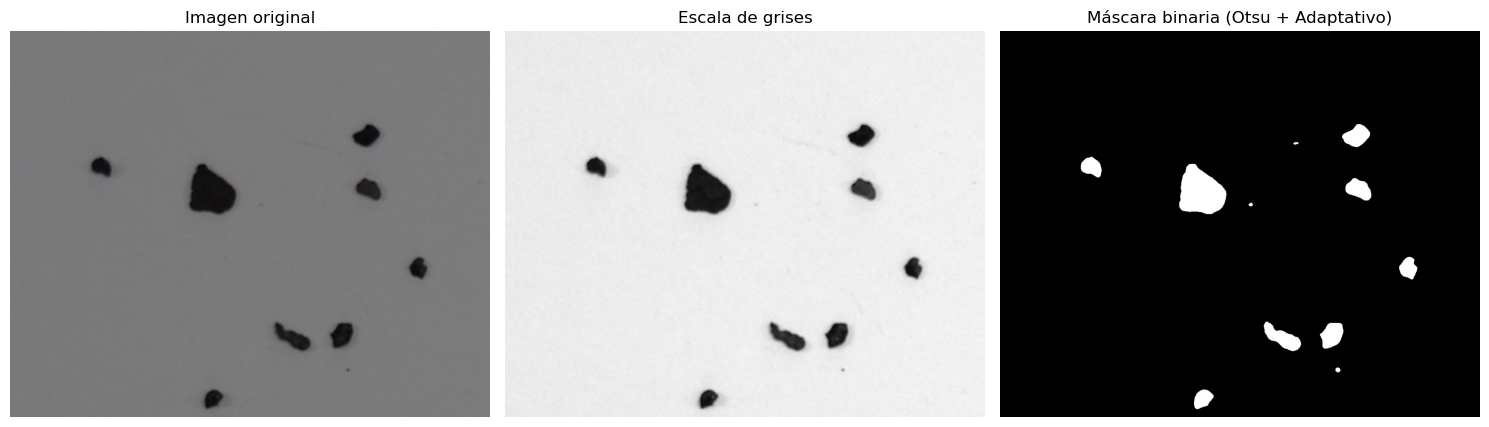

Procesando PEL.png (pellets_esfericos)...


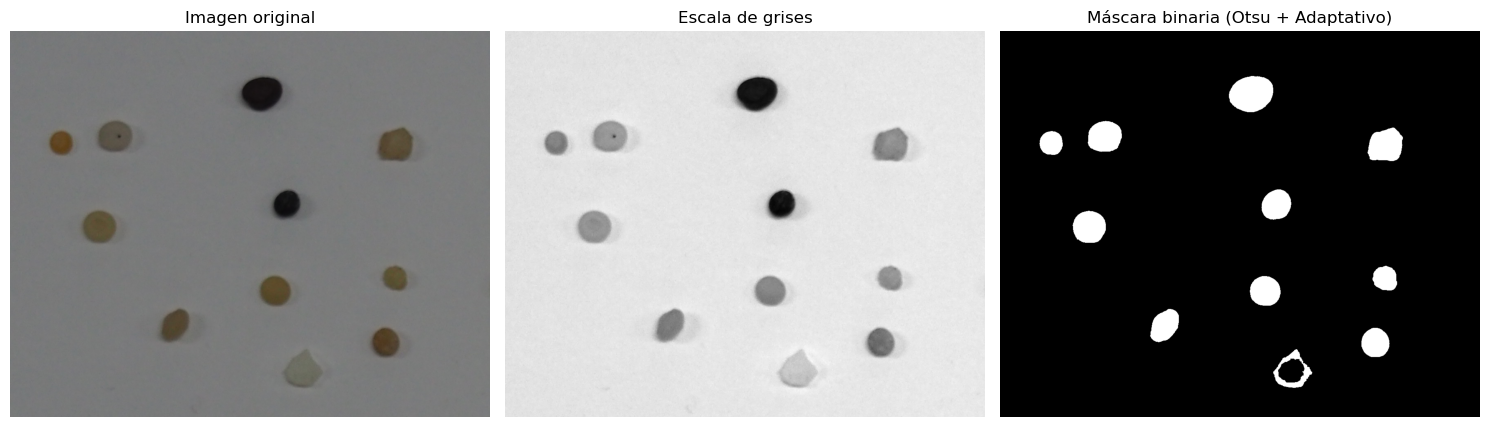

Procesando FRA.png (films_translucidos)...


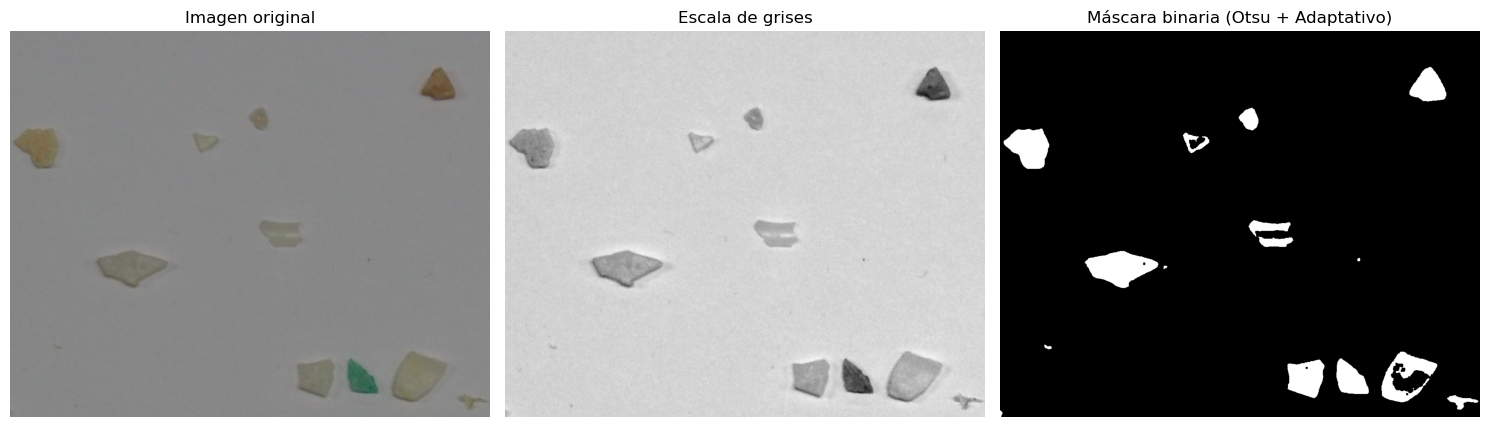

Balance de clases: {np.str_('films_translucidos'): np.int64(9), np.str_('fragmentos_negros'): np.int64(9), np.str_('pellets_esfericos'): np.int64(9)}

=== Evaluación ===

Matriz de confusión:
['fragmentos_negros', 'pellets_esfericos', 'films_translucidos']
[[ 6  4  4]
 [ 0 18 16]
 [ 0  1 48]]

Reporte:
                    precision    recall  f1-score   support

 fragmentos_negros      1.000     0.429     0.600        14
 pellets_esfericos      0.783     0.529     0.632        34
films_translucidos      0.706     0.980     0.821        49

          accuracy                          0.742        97
         macro avg      0.829     0.646     0.684        97
      weighted avg      0.775     0.742     0.722        97


✅ Precisión global: 74.23%


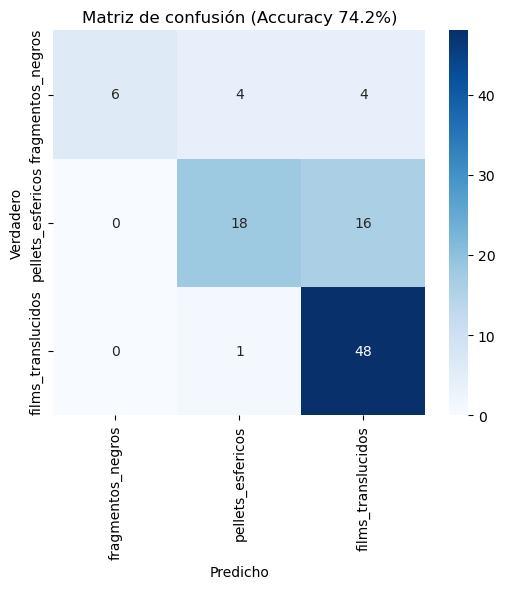

✅ Archivo 'predicciones_test.csv' guardado con éxito.


In [5]:
def main():
    print("\n=== Entrenamiento ===")
    X_train, y_train = prepare_training()
    clf = RandomForestClassifier(
        n_estimators=1200,      
        max_depth=18,
        min_samples_leaf=1,      
        class_weight="balanced",
        random_state=42
    )
    clf.fit(X_train, y_train)

    print("\n=== Evaluación ===")
    X_test, y_true, df = prepare_test()
    y_pred = clf.predict(X_test)

    for i in range(len(y_pred)):
        v_mean = X_test[i, 7]
        if v_mean < 85:
            y_pred[i] = "fragmentos_negros"
        elif v_mean > 155 and y_pred[i] == "fragmentos_negros":
            y_pred[i] = "films_translucidos"

    # Resultados
    labels = ["fragmentos_negros", "pellets_esfericos", "films_translucidos"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("\nMatriz de confusión:")
    print(labels)
    print(cm)

    print("\nReporte:")
    print(classification_report(y_true, y_pred, labels=labels, digits=3))
    acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Precisión global: {acc*100:.2f}%")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de confusión (Accuracy {acc*100:.1f}%)")
    plt.show()

    df["pred_class"] = y_pred
    df.to_csv("predicciones_test.csv", index=False)
    print("✅ Archivo 'predicciones_test.csv' guardado con éxito.")

if __name__ == "__main__":
    main()